In [1]:
from torchvision.datasets import  FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm
from typing import Tuple
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 64
N_CHANNELS = 1
EPOCHS = 10
LATENT_DIM = 100
CRITIC_STEPS = 5
LAMBDA_GP = 10

### Dataset

In [3]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.5], [.5])])

trainset = FashionMNIST(root='../data', train=True,  transform=transformer, download=True)
testset  = FashionMNIST(root='../data', train=False, transform=transformer, download=True)

trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True)

classes = {i:name for i, name in enumerate(trainset.classes)}
classes

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [4]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    imgs = (imgs + 1)/2
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1], cmap='gray')
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

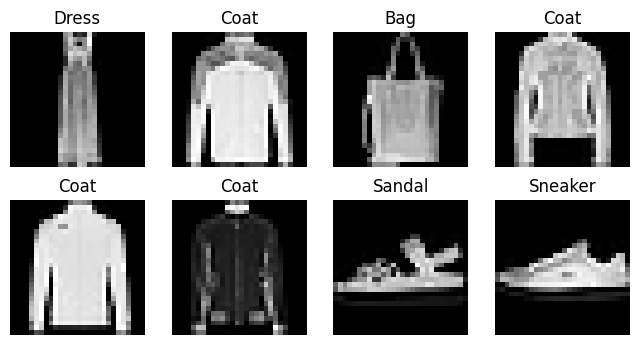

In [5]:
imgs, labels = next(iter(trainloader))
show_imgs(imgs[:8], labels[:8])

### Model

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_channels: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim * 2, 1, 1)),
            self._block(latent_dim*2, 256),
            self._block(256, 128, 3, 2, 1),
            self._block(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, n_channels, 4, 2, 1),        
            nn.Tanh())
        
    def _block(self, in_channels:int, out_channels:int, 
               kernel_size:int=4, stride:int=2, padding:int=0,
               momentum:float=0.9, negative_slope:float=0.2) -> nn.Module:
        return nn.Sequential(       
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size, stride, padding),
            nn.BatchNorm2d(num_features=out_channels, momentum=momentum),
            nn.LeakyReLU(negative_slope=negative_slope))

    def forward(self, labels, eps=None):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds) if eps is None else eps
        gen_input = torch.cat((cls_embds, eps), dim=-1)
        return self.model(gen_input)

In [7]:
class Critic(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Critic, self).__init__()
        self.n_classes = n_classes
        self.embd_size = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=1)
        self.model = nn.Sequential(
            self._block(img_shape[0]*2,  64, 3, 2, 1),
            self._block(64, 128, 3, 2, 1),
            self._block(128, 256, 3, 2, 1),

            nn.Conv2d(in_channels=256,
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0),
            nn.Flatten())
        
    def _block(self, in_channels:int, out_channels:int, kernel_size:int, 
               stride:int, padding:int, negative_slope:float=0.2) -> nn.Module:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size, stride, padding),
            nn.LeakyReLU(negative_slope=negative_slope))
    
    def forward(self, imgs, labels):
        embds = self.embeddings(labels).view(-1, 1, 1, 1)
        critic_input = torch.cat((imgs, embds.expand(-1, *imgs.shape[1:])), dim=1)
        return self.model(critic_input)

In [8]:
class CWGAN_GP(nn.Module):
    def __init__(self, generator, critic, LAMBDA_GP: float=10.0):
        super(CWGAN_GP, self).__init__()
        self.generator = generator
        self.critic = critic
        self.g_optimizer = None
        self.c_optimizer = None
        self.LAMBDA_GP = LAMBDA_GP

    def forward(self, labels, eps=None):
        return self.generator(labels, eps)
    
    def compile(self, g_optimizer, c_optimizer):
        self.g_optimizer = g_optimizer
        self.c_optimizer = c_optimizer
    
    def gradient_penalty(self, real_imgs, fake_imgs, labels):
        alpha = torch.rand((*real_imgs.shape[:1], 1, 1, 1)).to(real_imgs.device)
        diff = fake_imgs - real_imgs
        interpolation = real_imgs + alpha * diff
        preds = self.critic(interpolation, labels)
        grad_outputs = torch.ones_like(preds)
        gradients = torch.autograd.grad(
            outputs=preds,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True)[0]
        
        gradients = gradients.view(labels.shape[0], -1)
        grad_norm = (gradients+1e-16).norm(2, dim=1)
        return (torch.clamp(grad_norm - 1., min=0, max=None) ** 2).mean()
        return ((grad_norm-1)**2).mean()

### Model Initialization

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name())
!nvidia-smi 

generator = Generator(LATENT_DIM, N_CHANNELS, len(classes))
critic = Critic(len(classes), torch.tensor(imgs[0].shape))
# g_optimizer = optim.RMSprop(generator.parameters())
# c_optimizer = optim.RMSprop(critic.parameters())
g_optimizer = optim.Adam(generator.parameters())
c_optimizer = optim.Adam(critic.parameters())

model = CWGAN_GP(generator, critic, LAMBDA_GP)
model.compile(g_optimizer, c_optimizer)

NVIDIA GeForce RTX 4090
Wed Feb 28 04:12:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:01:00.0  On |                  Off |
|  0%   40C    P8             17W /  500W |    2454MiB /  24564MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------

### Training Implementation Scheme

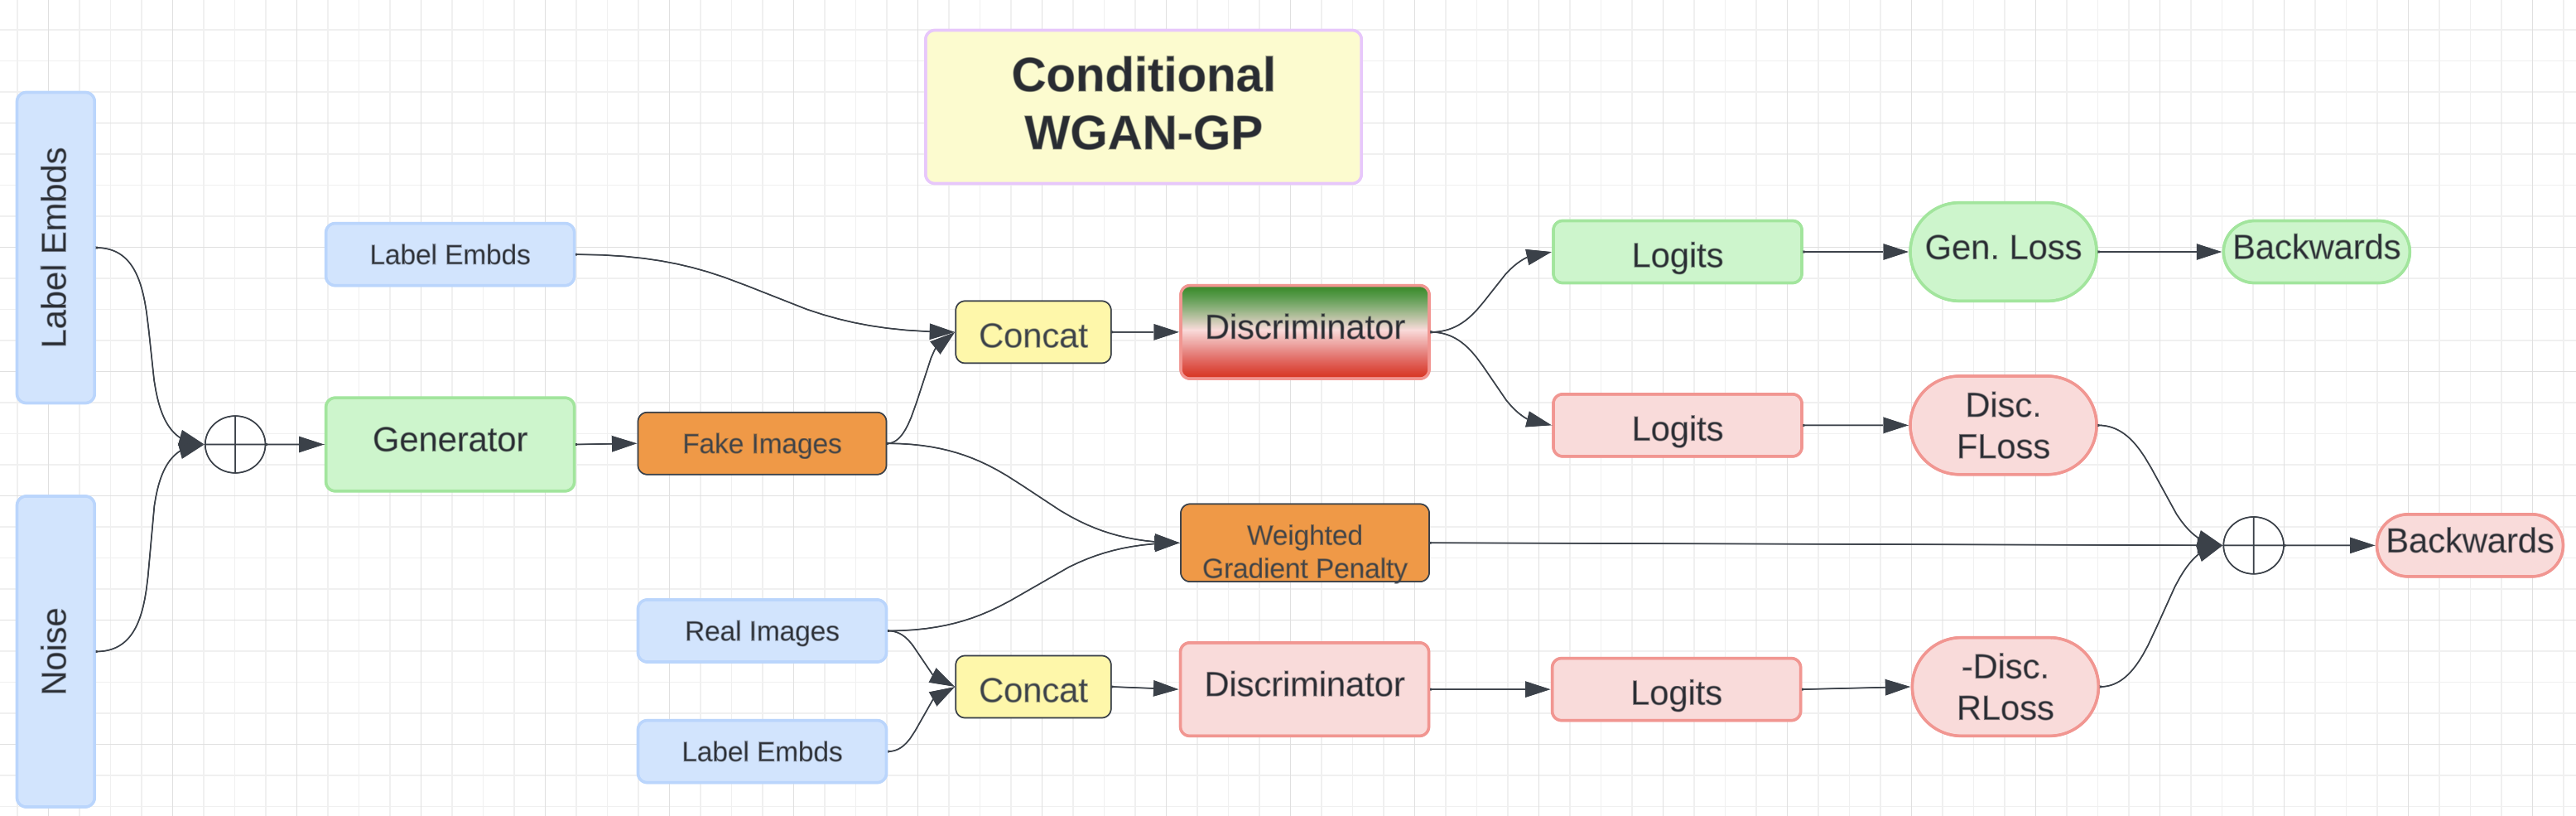

In [10]:
def train_step(model: nn.Module, trainloader: DataLoader, 
               device: torch.device, CRITIC_STEPS:int=3):
    model.train()
    loss = {'c_loss':.0, 'g_loss':.0, 'c_wass_loss':.0, 'c_gp':.0}
    
    for i, (real_imgs, labels) in enumerate(tqdm(trainloader)):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)

        # *******************
        # Train Critic
        # *******************
        
        # setting grads to 0 after last generator backprop
        model.c_optimizer.zero_grad()
        
        # generated images conditioned on labels
        fake_imgs = model.generator(labels)
        
        c_fake_logits = model.critic(fake_imgs, labels)
        c_real_logits = model.critic(real_imgs, labels)
        c_gp = model.gradient_penalty(real_imgs, fake_imgs, labels)
        c_wass_loss = c_fake_logits.mean() - c_real_logits.mean()
        c_loss = c_wass_loss + c_gp * model.LAMBDA_GP
        
        # critic backpropagation
        c_loss.backward()
        model.c_optimizer.step()

        loss['c_loss'] += c_loss.item()
        loss['c_gp'] += c_gp.item()
        loss['c_wass_loss'] += c_wass_loss.item()
        
        if (i+1) % CRITIC_STEPS == 0:
            # ***************
            # Train Generator
            # ***************
            
            # generator backpropagation        
            model.g_optimizer.zero_grad()
            fake_imgs = model.generator(labels)
            
            c_fake_logits = model.critic(fake_imgs, labels)
            g_loss = -torch.mean(c_fake_logits)
            
            g_loss.backward()
            model.g_optimizer.step()
            
            loss['g_loss'] += g_loss.item()

    n_batches = len(trainloader)
    for k in loss.keys():
        loss[k] /= (n_batches)
    loss['g_loss'] *= CRITIC_STEPS
    return loss

In [11]:
def test_step(model: nn.Module, testloader: DataLoader,
              device: torch.device):
    loss = {'c_loss':.0, 'g_loss':.0}
    model.eval()
    with torch.inference_mode():
        for real_imgs, labels in tqdm(testloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            fake_imgs = model.generator(labels)
            c_fake_logits = model.critic(fake_imgs, labels)
            c_real_logits = model.critic(real_imgs, labels)
            c_loss = c_fake_logits.mean() - c_real_logits.mean()
            g_loss = -torch.mean(c_fake_logits)
            
            loss['c_loss'] += c_loss.item()
            loss['g_loss'] += g_loss.item()
            
        n_batches = len(testloader)
        loss['c_loss'] /= n_batches
        loss['g_loss'] /= n_batches
        
    return loss

In [12]:
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, 
          EPOCHS: int, CRITIC_STEPS: int=3):
    model = model.to(device)
    results = {'train_loss':{'c_loss':[], 'g_loss':[], 'c_wass_loss':[], 'c_gp':[]},
               'test_loss':{'c_loss':[], 'g_loss':[]}}
    
    gif_rand_labels = torch.randint(0, 10, (64,)).to(device)
    eps = torch.randn((64, model.generator.latent_dim)).to(device) * 0.1
    gif_gen_imgs = []
    
    for epoch in range(1, EPOCHS+1):
        print(f"\nEPOCH ===================================> {epoch:3d}/{EPOCHS}")
        print("******************** Training ********************")
        train_results = train_step(model, trainloader, device, CRITIC_STEPS)
        print(f"Generator Loss: ------------------------> {train_results['g_loss']:.4f}")
        print(f"Critic Loss: ---------------------------> {train_results['c_loss']:.4f}")
        print(f"Critic Wasserstein Loss: ---------------> {train_results['c_wass_loss']:.4f}")
        print(f"Critic Gradient Penalty: ---------------> {train_results['c_gp']:.4f}")

        print("******************** Testing ********************")
        test_results = test_step(model, testloader, device)
        print(f"Generator Loss: ------------------------> {test_results['g_loss']:.4f}")
        print(f"Critic Loss: ---------------------------> {test_results['c_loss']:.4f}")
        
        # saving results
        for k, v in train_results.items():
            results['train_loss'][k].append(v)
        for k, v in test_results.items():
            results['test_loss'][k].append(v)
        
        # gif frame generation
        model.eval()
        with torch.inference_mode():
            gen_imgs = make_grid(model(gif_rand_labels, eps).to(device='cpu')).permute(1, 2, 0).numpy()
            gen_imgs = ((gen_imgs + 1) * 127.5).astype(np.uint8)
            gif_gen_imgs.append(gen_imgs)
    
        if epoch % 1 == 0:
            # save the training GIF after all frames have been collected
            imageio.mimsave(f'../gifs/fashion_cwgan_gp.gif', 
                            gif_gen_imgs, loop=65535)
            # save checkpoint
            torch.save({
                'epoch':epoch,
                'model_state_dict':model.state_dict(),
                'optimizers_state_dict': [model.g_optimizer.state_dict(),
                                          model.c_optimizer.state_dict()],
                'losses': results},  f'../models/fashion_cwgan_gp.pth')
            
    imageio.mimsave(f'../gifs/fashion_cwgan_gp_training.gif', gif_gen_imgs, loop=65535)
    return results 

In [13]:
results = train(model, trainloader, testloader, device, EPOCHS, CRITIC_STEPS)


EPOCH ===================================>   1/10
******************** Training ********************


100%|██████████| 938/938 [00:10<00:00, 93.13it/s] 


Generator Loss: ------------------------> -16.8797
Critic Loss: ---------------------------> -13.4340
Critic Wasserstein Loss: ---------------> -16.4771
Critic Gradient Penalty: ---------------> 0.3043
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 212.65it/s]


Generator Loss: ------------------------> 7.7092
Critic Loss: ---------------------------> -11.9934

EPOCH ===================================>   2/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 101.42it/s]


Generator Loss: ------------------------> -25.9515
Critic Loss: ---------------------------> -6.7522
Critic Wasserstein Loss: ---------------> -7.8522
Critic Gradient Penalty: ---------------> 0.1100
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 227.54it/s]


Generator Loss: ------------------------> -31.6414
Critic Loss: ---------------------------> -6.6008

EPOCH ===================================>   3/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 102.21it/s]


Generator Loss: ------------------------> -31.1277
Critic Loss: ---------------------------> -5.0016
Critic Wasserstein Loss: ---------------> -5.6559
Critic Gradient Penalty: ---------------> 0.0654
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 217.88it/s]


Generator Loss: ------------------------> 6.2959
Critic Loss: ---------------------------> -5.2194

EPOCH ===================================>   4/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 100.08it/s]


Generator Loss: ------------------------> -26.6460
Critic Loss: ---------------------------> -4.2672
Critic Wasserstein Loss: ---------------> -4.7620
Critic Gradient Penalty: ---------------> 0.0495
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 213.99it/s]


Generator Loss: ------------------------> -35.2998
Critic Loss: ---------------------------> -4.7496

EPOCH ===================================>   5/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 100.84it/s]


Generator Loss: ------------------------> -27.6367
Critic Loss: ---------------------------> -3.5796
Critic Wasserstein Loss: ---------------> -3.9504
Critic Gradient Penalty: ---------------> 0.0371
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 223.12it/s]


Generator Loss: ------------------------> -21.0114
Critic Loss: ---------------------------> -3.8252

EPOCH ===================================>   6/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 102.16it/s]


Generator Loss: ------------------------> -13.7939
Critic Loss: ---------------------------> -3.0641
Critic Wasserstein Loss: ---------------> -3.3538
Critic Gradient Penalty: ---------------> 0.0290
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 227.65it/s]


Generator Loss: ------------------------> -8.9791
Critic Loss: ---------------------------> -2.9593

EPOCH ===================================>   7/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 101.28it/s]


Generator Loss: ------------------------> -8.1493
Critic Loss: ---------------------------> -2.7366
Critic Wasserstein Loss: ---------------> -2.9833
Critic Gradient Penalty: ---------------> 0.0247
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 225.59it/s]


Generator Loss: ------------------------> -8.2499
Critic Loss: ---------------------------> -3.3885

EPOCH ===================================>   8/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 101.99it/s]


Generator Loss: ------------------------> -6.3843
Critic Loss: ---------------------------> -2.4499
Critic Wasserstein Loss: ---------------> -2.6552
Critic Gradient Penalty: ---------------> 0.0205
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 220.38it/s]


Generator Loss: ------------------------> -1.2157
Critic Loss: ---------------------------> -2.5859

EPOCH ===================================>   9/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 101.45it/s]


Generator Loss: ------------------------> -4.3150
Critic Loss: ---------------------------> -2.2778
Critic Wasserstein Loss: ---------------> -2.4659
Critic Gradient Penalty: ---------------> 0.0188
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 223.57it/s]


Generator Loss: ------------------------> 1.5496
Critic Loss: ---------------------------> -1.9840

EPOCH ===================================>  10/10
******************** Training ********************


100%|██████████| 938/938 [00:09<00:00, 99.40it/s] 


Generator Loss: ------------------------> -4.8982
Critic Loss: ---------------------------> -2.1521
Critic Wasserstein Loss: ---------------> -2.3184
Critic Gradient Penalty: ---------------> 0.0166
******************** Testing ********************


100%|██████████| 157/157 [00:00<00:00, 217.49it/s]


Generator Loss: ------------------------> -5.4165
Critic Loss: ---------------------------> -2.3451


### Load The Model

In [14]:
generator = Generator(LATENT_DIM, N_CHANNELS, len(classes))
critic = Critic(len(classes), torch.tensor(imgs[0].shape))
g_optimizer = optim.Adam(generator.parameters())
c_optimizer = optim.Adam(critic.parameters())

saved_model = CWGAN_GP(generator, critic)

checkpoint = torch.load("../models/fashion_cwgan_gp.pth")
saved_model.load_state_dict(checkpoint['model_state_dict'])
g_optimizer.load_state_dict(checkpoint['optimizers_state_dict'][0])
c_optimizer.load_state_dict(checkpoint['optimizers_state_dict'][1])
results = checkpoint['losses']

saved_model.compile(g_optimizer, c_optimizer)

### Visualization

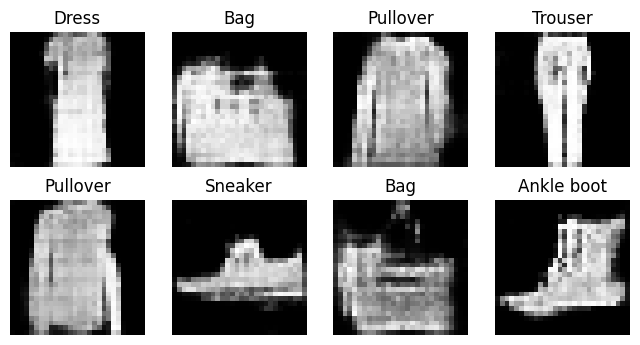

In [17]:
rand_labels = torch.randint(0, 10, (8,))
saved_model.eval()
with torch.inference_mode():
    gen_imgs = saved_model(rand_labels)
show_imgs(gen_imgs, rand_labels)

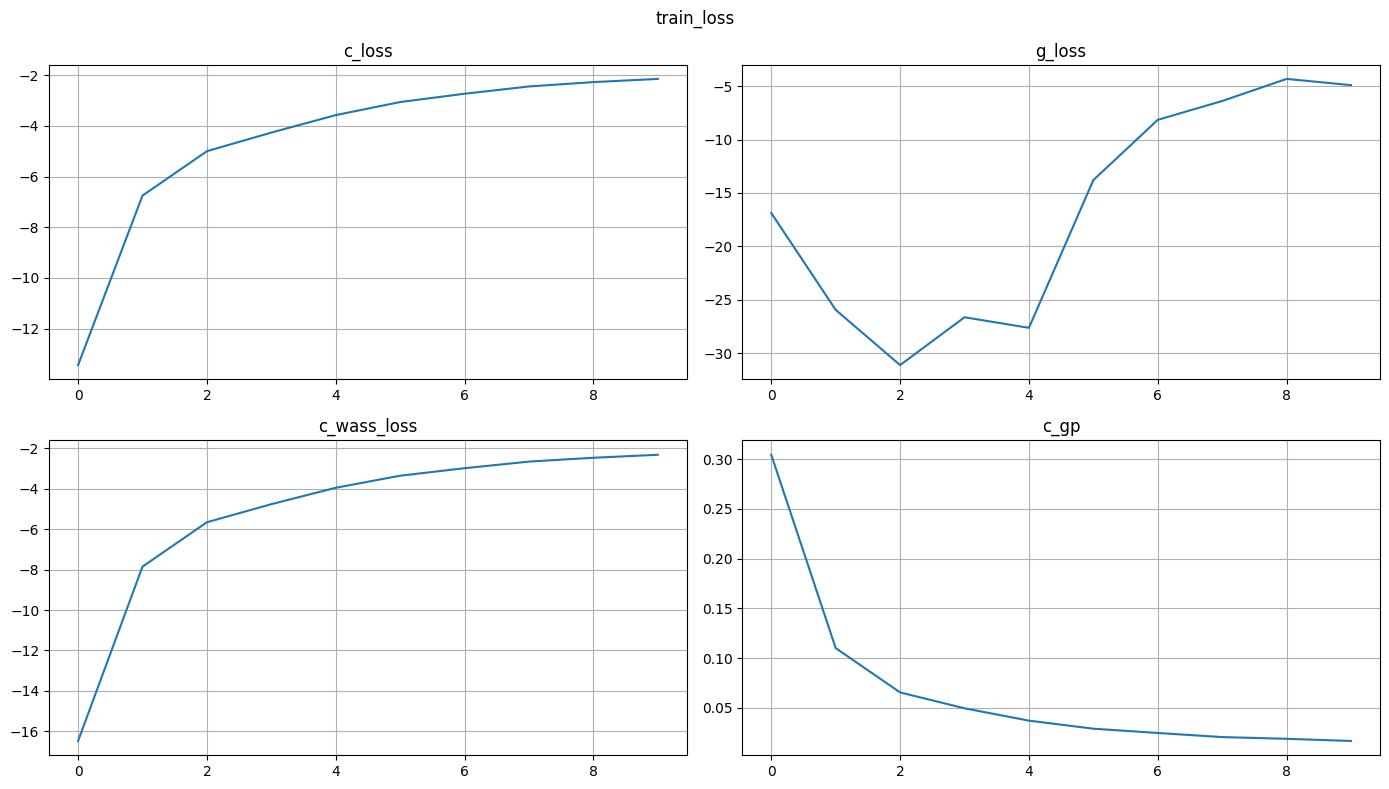

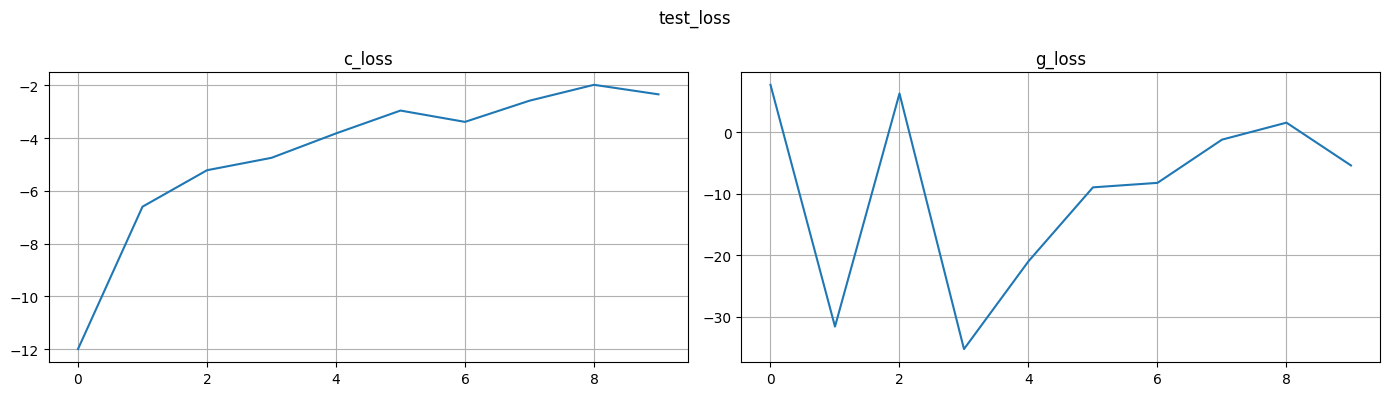

In [16]:
def plot(results, subs, title, train=True):
    section = 'train_loss' if train else 'test_loss'
    plt.subplot(int(subs))
    plt.plot(results[section][title])
    plt.title(title)
    plt.suptitle(section)
    plt.tight_layout()
    plt.grid(True)
    
##############
# Train Losses
##############
plt.figure(figsize=(14, 8))
plot(results, '221', 'c_loss')
plot(results, '222', 'g_loss')
plot(results, '223', 'c_wass_loss')
plot(results, '224', 'c_gp')
plt.show()

#############
# Test Losses
#############
plt.figure(figsize=(14, 4))
plot(results, '121', 'c_loss', False)
plot(results, '122', 'g_loss', False)
plt.show()